import the relevant packages

In [24]:
import csv as csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import bokeh  modules
import bokeh.io
import bokeh.mpl
import bokeh.plotting

# plot inline
%matplotlib inline
#bokeh.io.output_notebook()

from bokeh.resources import INLINE
from bokeh.io import output_notebook
output_notebook(resources=INLINE)

#figures as high resolution PNGs
%config InlineBackend.figure_formats = {'png','retina'}

Loading BokehJS ...

read the training and test dataset and summary statistics

In [25]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')
#list(train_df)
#print("fields:",train_df.columns.values.tolist()) 
#train_df.info()
train_df.shape
test_df.head(2)
#train_df.info()
#print(train_df['Ticket'].describe())
#print(set(train_df['Fare']))

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


missing values in train: Age 714/891, Embarked 889/891, Cabin 204
missing values in test: Age 332/418, Fare 417/418, Cabin 91
survived, Pclass, Age, sibSp, Parch, Fare are in numerical format. String: Name, Sex,Ticket, Cabin, Embarked. convert to categorical: sex, Pclass, survived

Plot the histogram for age and replace missing values with mean/median. 

In [26]:
from bokeh.plotting import show
from bokeh.charts import Histogram, Area
from bokeh.layouts import row
tmp = train_df.Age.dropna()
tmpSurv = train_df['Survived'][train_df['Age'].notnull()]
tmpDF = pd.DataFrame({'Age':tmp, 'Surv':tmpSurv})
hist = Histogram(tmpDF, values='Age', label='Surv',color='Surv',legend='top_right',bins=16,title="Age Vs Survival", width=350,height=350)
#hist = Histogram(tmp, bins=50, legend=True,width=400, height=400, notebook=True)
ageBins = list(range(int(np.ceil(tmp.max()/10))+1));
ageBins = [10*x for x in ageBins]
alive = np.zeros(len(ageBins)-1)
dead = np.zeros(len(ageBins)-1)
midAge = np.zeros(len(ageBins)-1)
from collections import OrderedDict
sumFS = OrderedDict()
for val in range(len(ageBins)-1):
    a = tmpSurv[(tmp>=ageBins[val]) & (tmp<ageBins[val+1])]
    alive[val] = sum(a)/len(a)
    dead[val] = (len(a)-sum(a))/len(a)
    del a
    midAge[val]=ageBins[val+1]-5
sumFS['alive'] = alive;
sumFS['dead'] = dead;
sumFS['age']=midAge;
#print([sumFS['alive']/(sumFS['alive']+sumFS['dead'])])
p1 = Area(sumFS, x='age',y=['alive','dead'],title="age vs survival", stack=True,width=400, height=400,legend='top_right')
show(row(hist,p1))
del hist
del ageBins, alive, dead, midAge, sumFS
# since the age is all rounded to integers, use median
naAge = np.median(tmp) 
del tmp
#tmp = train_df['Age'].copy()
#tmp[train_df['Age'].isnull()]=naAge
#train_df['age']=tmp;
#del tmp
#train_df.drop('Age',axis=1,inplace=True)

probability of survival with age in decades: [0.61 0.4 0.35 0.44 0.38 0.42 0.31 0].
kids aged 0-10 had higher change of survival, 70-80 all died, 10-60 not much difference in chance of survival.
box plot for gender, class, embarked 

In [28]:
from bokeh.charts import Bar
a=train_df['Sex']
b=train_df['Pclass']
c=train_df['Embarked']
d=train_df['Survived']
catFeatures = pd.DataFrame({'Sex':a, 'Pclass':b, 'Embarked':c, 'Survived':d})
for name, values in catFeatures.iteritems():
    if (name!='Survived'):
        print(train_df.groupby([name,'Survived']).size()/(train_df.groupby(name).size()))
p2 = Bar(catFeatures,label='Embarked', values='Embarked', agg='count',stack='Survived',title="Embarked vs survival", legend='top_left',width=250, height=250)
p3 = Bar(catFeatures,label='Sex', values='Sex', agg='count',stack='Survived',title="Gender vs survival", legend='top_left',width=250, height=250)
p4 = Bar(catFeatures,label='Pclass', values='Pclass', agg='count',stack='Survived',title="ticket class vs survival", legend='top_left',width=250, height=250)
show(row(p2,p3,p4))
del catFeatures

Embarked  Survived
C         0           0.446429
          1           0.553571
Q         0           0.610390
          1           0.389610
S         0           0.663043
          1           0.336957
dtype: float64
Pclass  Survived
1       0           0.370370
        1           0.629630
2       0           0.527174
        1           0.472826
3       0           0.757637
        1           0.242363
dtype: float64
Sex     Survived
female  0           0.257962
        1           0.742038
male    0           0.811092
        1           0.188908
dtype: float64


Summary: probability of survival with: port - C>S=Q ; Gender - female > male; ticket class - 1>2>3.
histograms of fare and family size

In [29]:
train_df['familySize']=train_df['Parch']+train_df['SibSp']
test_df['familySize']=test_df['Parch']+test_df['SibSp']
p0 = Bar(train_df, label='Parch',values='Parch',agg='count',stack='Survived',title="Parch vs survival", legend="top_right",width=250, height=250)
p1 = Bar(train_df, label='SibSp',values='SibSp',agg='count',stack='Survived',title="SibSp vs survival", legend="top_right",width=250, height=250)
def getTiNum(val):
    a = val.split(' ')
    if len(a)>1:
        return a[1]
    else:
        return a[0]

tiNum = train_df['Ticket'].apply(lambda x: getTiNum(x)) 
tiNumLen = tiNum.apply(lambda x: len(x))
print("trTiNumLen",np.unique(tiNumLen))
train_df['tiNumLen'] = tiNumLen

tiNum = test_df['Ticket'].apply(lambda x: getTiNum(x)) 
tiNumLen = tiNum.apply(lambda x: len(x))
print("teTiNumLen",np.unique(tiNumLen))
test_df['tiNumLen'] = tiNumLen

def getTiStr(val):
    a = val.split(' ')
    if len(a)>1:
        return a[0]
    else:
        return 'None'
tiStr = train_df['Ticket'].apply(lambda x: getTiStr(x)) 

print(np.unique(tiStr))
p2 = Bar(train_df, label='tiNumLen',values='tiNumLen',agg='count',stack='Survived',title="tiNumLen vs survival", legend="top_left",width=250, height=250)
show(row(p0,p1,p2))

trTiNumLen [1 2 3 4 5 6 7]
teTiNumLen [1 2 3 4 5 6 7]
['A./5.' 'A.5.' 'A/4' 'A/4.' 'A/5' 'A/5.' 'A/S' 'A4.' 'C' 'C.A.'
 'C.A./SOTON' 'CA' 'CA.' 'F.C.' 'F.C.C.' 'Fa' 'None' 'P/PP' 'PC' 'PP'
 'S.C./A.4.' 'S.C./PARIS' 'S.O./P.P.' 'S.O.C.' 'S.O.P.' 'S.P.' 'S.W./PP'
 'SC' 'SC/AH' 'SC/PARIS' 'SC/Paris' 'SCO/W' 'SO/C' 'SOTON/O.Q.' 'SOTON/O2'
 'SOTON/OQ' 'STON/O' 'STON/O2.' 'SW/PP' 'W./C.' 'W.E.P.' 'W/C' 'WE/P']


In [30]:
p0 = Bar(train_df, label='familySize',values='familySize',agg='count',stack='Survived',title="FamilySize vs survival", legend="top_right",width=300, height=300)
'''a=train_df['Fare'].copy()
a[train_df['familySize']>1]=a[train_df['familySize']>1]/(train_df['familySize'][train_df['familySize']>1])
train_df['indvFare']=a
a=test_df['Fare'].copy()
a[test_df['familySize']>1]=a[test_df['familySize']>1]/(test_df['familySize'][test_df['familySize']>1])
test_df['indvFare']=a'''

fareBins=[0,10,20,30,40,50,60,70,80,90,100,125,150,200,250,300,np.ceil(max(train_df['Fare']))]
survFare=pd.DataFrame(train_df,columns=['Fare','Survived']).copy()
survFare['Survived']=survFare['Survived'].astype('int')
#tmp = ['20-30' for x in range(len(survFare['Fare']))]
tmp=np.zeros(len(survFare['Survived']))
print(len(tmp))
for i in range(len(fareBins)-1):
    a=[str(fareBins[i]),str(fareBins[i+1])];
    a="_".join(a)
    idx=np.where((survFare['Fare']>=fareBins[i])&(survFare['Fare']<fareBins[i+1]))
    for j in idx[0]:
        if (fareBins[i]<100):
            tmp[j]=fareBins[i]+5
        elif (fareBins[i]>=100) & (fareBins[i]<150):
            tmp[j]=fareBins[i]+12.5
        elif (fareBins[i]>=150) & (fareBins[i]<300):
            tmp[j]=fareBins[i]+25
        elif (fareBins[i]>=300):
            tmp[j]=fareBins[-1]
        #tmp[i]=a
    del a
survFare['fareRange']=tmp
nPass = len(survFare['fareRange'])
#rep0 = survFare.groupby('fareRange').agg({"survival":{'n':len,'alive':lambda x: (sum(x)/len(x)),'dead':lambda x:(len(x)-sum(x))/len(x)}})
rep0 = survFare.groupby('fareRange').agg({"Survived":{'n':len,'alive':sum,'dead':lambda x:(len(x)-sum(x))}})
rep0.columns=rep0.columns.droplevel()
rep0=rep0.reset_index()
rep0['alive']=(rep0['alive']/rep0['n'])
rep0['dead']=(rep0['dead']/rep0['n'])
print(rep0)
p1 = Area(rep0,x='fareRange', y=['alive','dead'],title="fare vs survival", stack=True,width=300, height=300,legend='top_right')
hist2 = Histogram(survFare, values='fareRange', label='Survived',color='Survived',legend='top_right',bins=fareBins, palette=['blue', 'yellow'],title="survival by fare", width=300,height=300)
show(row(p0,p1,hist2))

891
    fareRange     alive    n      dead
0         5.0  0.199405  336  0.800595
1        15.0  0.424581  179  0.575419
2        25.0  0.426471  136  0.573529
3        35.0  0.437500   64  0.562500
4        45.0  0.266667   15  0.733333
5        55.0  0.692308   39  0.307692
6        65.0  0.352941   17  0.647059
7        75.0  0.586207   29  0.413793
8        85.0  0.866667   15  0.133333
9        95.0  0.875000    8  0.125000
10      112.5  0.733333   15  0.266667
11      137.5  0.888889    9  0.111111
12      175.0  0.666667    9  0.333333
13      225.0  0.636364   11  0.363636
14      275.0  0.666667    6  0.333333
15      513.0  1.000000    3  0.000000


Families with n<=3 have a better chance of survival than those with n>3. without accounting for N in each fare bin, it seems the probability of survival increases with fare with the range (80-160) having a higher survival. 
Fare is not individual fare for families but total!! Assume kids (Age<15) paid half the fare. 

Lets add more features. thanks to: http://trevorstephens.com/kaggle-titanic-tutorial/getting-started-with-r/ unexplored Name and Cabin. The only title in test not in train is Dona. Combine: Mme, Mlle->Mme Capt, Col,Don, Major and Sir ->Sir Dona, Lady, Jonkheer,the Countess->Lady Mr+Mrs+Miss: 517+183+125 = 825!!

In [31]:
from collections import Counter
import re
trFN= train_df['Name'].apply(lambda x: x.split(",")[1])
trTitle = trFN.apply(lambda x: x.split(".")[0].strip())
titleF = ['Mme','Mlle','Dona','Jonkheer','the Countess']
f_regex = re.compile('|'.join(map(re.escape, titleF)))
trTitle = [f_regex.sub('Lady',word) for word in trTitle]
titleM =['Capt','Col','Don','Major']
m_regex = re.compile('|'.join(map(re.escape, titleM)))
trTitle = [m_regex.sub('Sir',word) for word in trTitle]
trTitle = [word.replace('Ms','Miss') for word in trTitle]
nTit = Counter(trTitle)
print(nTit)
train_df['title']=trTitle
teFN= test_df['Name'].apply(lambda x: x.split(",")[1])
teTitle = teFN.apply(lambda x: x.split(".")[0].strip())
teTitle = [f_regex.sub('Lady',word) for word in teTitle]
teTitle = [m_regex.sub('Sir',word) for word in teTitle]
teTitle = [word.replace('Ms','Miss') for word in teTitle]
nTit = Counter(teTitle)
print(nTit)
test_df['title']=teTitle

Counter({'Mr': 517, 'Miss': 183, 'Mrs': 125, 'Master': 40, 'Sir': 7, 'Dr': 7, 'Rev': 6, 'Lady': 6})
Counter({'Mr': 240, 'Miss': 79, 'Mrs': 72, 'Master': 21, 'Sir': 2, 'Rev': 2, 'Dr': 1, 'Lady': 1})


combine lastname and familySize. 667 unique values for lastname!
lastname + familySize has 701 unique values

In [65]:
teLN= train_df['Name'].apply(lambda x: x.split(",")[0].strip())
lnFS = train_df['familySize'].astype(str).str.cat(teLN)
lnFS[train_df['familySize']<3]='None'
train_df['familyID']=lnFS
print(len(np.unique(train_df['familyID'])))
#print(np.unique(train_df['familyID']))
teLN= test_df['Name'].apply(lambda x: x.split(",")[0].strip())
lnFS = test_df['familySize'].astype(str).str.cat(teLN)
lnFS[(test_df['familySize']<3)]='None'
test_df['familyID']=lnFS
#print(np.unique(test_df['familyID']))
print(len(np.unique(test_df['familyID'])))
#print(train_df['familyID'][(train_df['familySize']==2) & (train_df['Pclass']==2|3)])

28
22


117,60,14,6,5,3,2,2 families with n=1,2,3,4,5,6,7,10. Combining test & train 28+3 = 31 unique values
Imputing missing values: train-Age(714/891),Embarked(889/891),Cabin(204/891). test - Age(332/418),Fare(417/418),Cabin(91/418).
Lets fill the missing Fare in test data set

In [66]:
print(test_df[pd.isnull(test_df['Fare'])])
tmp = test_df['Fare'].copy()
tmp[pd.isnull(tmp)] = test_df['Fare'][test_df['Pclass']==3].dropna().mode().values
test_df.drop('Fare',axis=1,inplace=True)
test_df['Fare']=tmp

Empty DataFrame
Columns: [PassengerId, Pclass, Name, Sex, SibSp, Parch, Ticket, Cabin, Embarked, familySize, tiNumLen, title, familyID, deck, logFare, Fare, Age]
Index: []


Lets fill the missing Embarked in training data set. No family accompanying. Both were female, in deck B, paid the same
Just replace with mode

In [67]:
print(train_df[pd.isnull(train_df['Embarked'])])
tmp = train_df['Embarked'].copy()
if len(train_df.Embarked[ train_df.Embarked.isnull() ]) > 0:
    tmp[train_df.Embarked.isnull()] = train_df['Embarked'].dropna().mode().values
train_df.drop('Embarked',axis=1,inplace=True)
train_df['Embarked'] = tmp;
del tmp

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, SibSp, Parch, Ticket, Fare, Cabin, familySize, tiNumLen, title, familyID, deck, logFare, Embarked, Age]
Index: []


get Age as a function of (Pclass,fare,title,famSize)

In [68]:
A = train_df[pd.notnull(train_df['Age'])].copy()
A.drop('Survived',axis=1,inplace=True)
B=test_df[pd.notnull(test_df['Age'])].copy()
B.set_index([np.linspace(len(A),len(A)+len(B)-1,len(B),dtype=np.int32)],inplace=True)
fullDS = pd.concat([A,B],axis=0)
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
le = LabelEncoder()
le = le.fit(list(set(fullDS['title'])))
numTitle = le.transform(fullDS['title'].reshape(-1,1))
numPclass=fullDS['Pclass'].astype('int').reshape(-1,1)
A00 = pd.DataFrame(fullDS,columns=['Fare','familySize']).copy()
A01 = A00.as_matrix()
AgIP = np.concatenate((numTitle,numPclass,A01),axis=1)
AgOP = fullDS['Age'].copy()
clf = RandomForestRegressor(n_estimators=100,min_samples_leaf=15,oob_score=1,n_jobs=-1)
rfClf = clf.fit(AgIP,AgOP)

lets predict the missing ages

In [69]:
missAge = np.where(train_df['Age'].isnull())
age = train_df['Age'].copy()
for j in missAge[0]:
        ip0 = le.transform(train_df['title'][j])
        ip1 = train_df['Pclass'][j]
        ip2 = train_df['Fare'][j]
        ip3 = train_df['familySize'][j]
        ip = np.array([ip0,ip1,ip2,ip3]).reshape(1,-1)
        age[j]=rfClf.predict(ip)
train_df.drop('Age',axis=1,inplace=True)
train_df['Age']=age

missAge = np.where(test_df['Age'].isnull())
age = test_df['Age'].copy()
for j in missAge[0]:
        ip0 = le.transform(test_df['title'][j])
        ip1 = test_df['Pclass'][j]
        ip2 = test_df['Fare'][j]
        ip3 = test_df['familySize'][j]
        ip = np.array([ip0,ip1,ip2,ip3]).reshape(1,-1)
        age[j]=rfClf.predict(ip)
test_df.drop('Age',axis=1,inplace=True)
test_df['Age']=age
tmpSurv = pd.DataFrame(train_df,columns=['Age','Survived']).copy()
hist = Histogram(tmpSurv, values='Age', label='Survived',color='Survived',legend='top_right',bins=16,title="Age Vs Survival", width=350,height=350)
show(hist)

now explore Cabin: too many missing values (204/891). all this for adding 4 values in train_df, yikes!

In [70]:
a = train_df['Cabin'].astype('str').apply(lambda x: x[0].strip())
missCabin = np.where((a=='n')&(train_df['familySize']>0))
missCabinFam=[]
for j in missCabin[0]:
    missCabinFam.append(train_df['familyID'][j])
b=set(missCabinFam)
for j in b:
    currDeck = a[train_df['familyID']==j]
    if(currDeck.any()!='n'):
        deck = currDeck.values
        posVal = deck[deck!='n'][0]
        ind = currDeck.index
        a[ind]=posVal
train_df['deck']=a

a = test_df['Cabin'].astype('str').apply(lambda x: x[0].strip())
missCabin = np.where((a=='n')&(test_df['familySize']>0))
missCabinFam=[]
for j in missCabin[0]:
    missCabinFam.append(test_df['familyID'][j])
b=set(missCabinFam)
for j in b:
    currDeck = a[test_df['familyID']==j]
    if(currDeck.any()!='n'):
        deck = currDeck.values
        posVal = deck[deck!='n'][0]
        ind = currDeck.index
        a[ind]=posVal
test_df['deck']=a

convert fare to log scale

In [71]:
tmp = np.log(train_df['Fare'])
tmp[train_df['Fare']==0]=-1
train_df['logFare']=tmp
tmp = np.log(test_df['Fare'])
tmp[test_df['Fare']==0]=-1
test_df['logFare']=tmp

features to use: Pclass, Sex, Embarked,title,familyID,Fare,Age,deck. Encode categorical variables - title,familyID,deck. (Pclass,Sex,Embarked)

In [72]:
train_sub=pd.DataFrame(train_df,columns=['title','familyID','deck','Parch','SibSp']).copy()
test_sub=pd.DataFrame(test_df,columns=['title','familyID','deck','Parch','SibSp']).copy()
test_sub.set_index([np.linspace(len(train_sub),len(train_sub)+len(test_sub)-1,len(test_sub),dtype=np.int32)],inplace=True)
comb =  pd.concat([train_sub,test_sub],axis=0)

trEmbarked = train_df['Embarked'].map( {'C': 0, 'Q': 1,'S':2} ).astype('int').reshape(-1,1)
trPclass = train_df['Pclass'].astype('int').reshape(-1,1)
trSex = train_df['Sex'].map( {'male': 0, 'female': 1} ).astype('int').reshape(-1,1)

teEmbarked = test_df['Embarked'].map( {'C': 0, 'Q': 1,'S':2} ).astype('int').reshape(-1,1)
tePclass = test_df['Pclass'].astype('int').reshape(-1,1)
teSex = test_df['Sex'].map( {'male': 0, 'female': 1} ).astype('int').reshape(-1,1)

le = LabelEncoder()
leTitle = le.fit(list(set(comb['title'])))
trTitle = leTitle.transform(train_df['title']).reshape(-1,1)
teTitle = leTitle.transform(test_df['title']).reshape(-1,1)

le = LabelEncoder()
leFamilyID = le.fit(list(set(comb['familyID'])))
trfamilyID = leFamilyID.transform(train_df['familyID']).reshape(-1,1)
print("trFamilyID:",np.unique(trfamilyID))
tefamilyID = leFamilyID.transform(test_df['familyID']).reshape(-1,1)
print("teFamilyID:",np.unique(tefamilyID))

le = LabelEncoder()
leDeck = le.fit(list(set(comb['deck'])))
trDeck = leDeck.transform(train_df['deck']).reshape(-1,1)
print("trDeck:",np.unique(trDeck))
teDeck = leDeck.transform(test_df['deck']).reshape(-1,1)
print("teDeck:",np.unique(teDeck))

trAge = (np.round(train_df['Age'],-1)/10).reshape(-1,1)
teAge = (np.round(test_df['Age'],-1)/10).reshape(-1,1)

#trFare = np.round(train_df['Fare'],-1).reshape(-1,1)
#teFare = np.round(test_df['Fare'],-1).reshape(-1,1)

trFare = train_df['logFare'].reshape(-1,1)
teFare = test_df['logFare'].reshape(-1,1)

trParch = train_df['Parch'].reshape(-1,1)
teParch = test_df['Parch'].reshape(-1,1)

trSibSp = train_df['SibSp'].reshape(-1,1)
teSibSp = test_df['SibSp'].reshape(-1,1)

trTicLen = train_df['tiNumLen'].reshape(-1,1)
teTicLen = test_df['tiNumLen'].reshape(-1,1)

#Xtrain=np.concatenate((trEmbarked,trPclass,trSex,trTitle,trfamilyID,trDeck,trAge,trFare,trParch,trSibSp),axis=1)
#Xtest=np.concatenate((teEmbarked,tePclass,teSex,teTitle,tefamilyID,teDeck,teAge,teFare,teParch,teSibSp),axis=1)
Ytrain = train_df['Survived']

trFamilyID: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 15 16 17 19 20 21 22 23 24 25 26 27
 28 29 30]
teFamilyID: [ 0  1  4  6  7  8  9 11 12 14 15 16 18 19 20 21 22 24 27 28 29 30]
trDeck: [0 1 2 3 4 5 6 7 8]
teDeck: [0 1 2 3 4 5 6 8]


37 features:
0-2:port,3-5:class,6-7:sex,8-15:title,16:familyId,17-25:deck,26:age,27:fare,28-36:familySize
Lets fit a logistic regression model with 

In [73]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enEm = enc.fit(trEmbarked)
trEm = enEm.transform(trEmbarked).toarray()
teEm = enEm.transform(teEmbarked).toarray()

enPcl = enc.fit(trPclass)
trPcl = enPcl.transform(trPclass).toarray()
tePcl = enPcl.transform(tePclass).toarray()

enSx = enc.fit(trSex)
trSx = enSx.transform(trSex).toarray()
teSx = enSx.transform(teSex).toarray()

enTit = enc.fit(trTitle)
trTit = enTit.transform(trTitle).toarray()
teTit = enTit.transform(teTitle).toarray()

enDe = enc.fit(trDeck)
trDe = enDe.transform(trDeck).toarray()
teDe = enDe.transform(teDeck).toarray()

#trParch: [0 1 2 3 4 5 6];teParch: [0 1 2 3 4 5 6 7]
enPc = enc.fit(teParch)
trPc = enPc.transform(trParch).toarray()
tePc = enPc.transform(teParch).toarray()

#trSibSp: [0 1 2 3 4 5 6];teSibSp: [0 1 2 3 4 5 6]
enSS = enc.fit(trSibSp)
trSS = enSS.transform(trSibSp).toarray()
teSS = enSS.transform(teSibSp).toarray()

combFamID = leFamilyID.transform(comb['familyID']).reshape(-1,1)
enFID = enc.fit(combFamID)
trFamID = enFID.transform(trfamilyID).toarray()
teFamID = enFID.transform(tefamilyID).toarray()

#trTiNumLen [1 2 3 4 5 6 7]; teTiNumLen [1 2 3 4 5 6 7]
enTiNL = enc.fit(trTicLen)
trTiNL = enTiNL.transform(trTicLen).toarray()
teTiNL = enTiNL.transform(teTicLen).toarray()

XtrainLong=np.concatenate((trEm,trPcl,trSx,trTit,trFamID,trDe,trAge,trFare,trPc,trSS,trTiNL),axis=1)
XtestLong=np.concatenate((teEm,tePcl,teSx,teTit,teFamID,teDe,teAge,teFare,tePc,teSS,teTiNL),axis=1)
print(XtrainLong.shape)

from sklearn.cross_validation import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(XtrainLong,Ytrain,test_size=0.2,random_state=0)
print(X_train.shape)

(891, 80)
(712, 80)


In [74]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=20,max_iter=100,solver='newton-cg')
logreg = logreg.fit(X_train,Y_train)
#print(logreg.coef_)
#print(logreg.intercept_)
logreg.score(X_test,Y_test)
#imp = Imputer(missing_values='NaN', strategy='median', axis=0,verbose=1)
#imp.fit(X0)
#X1=imp.transform(X0)

0.82681564245810057

Lets do the same with decision trees

0.854748603352


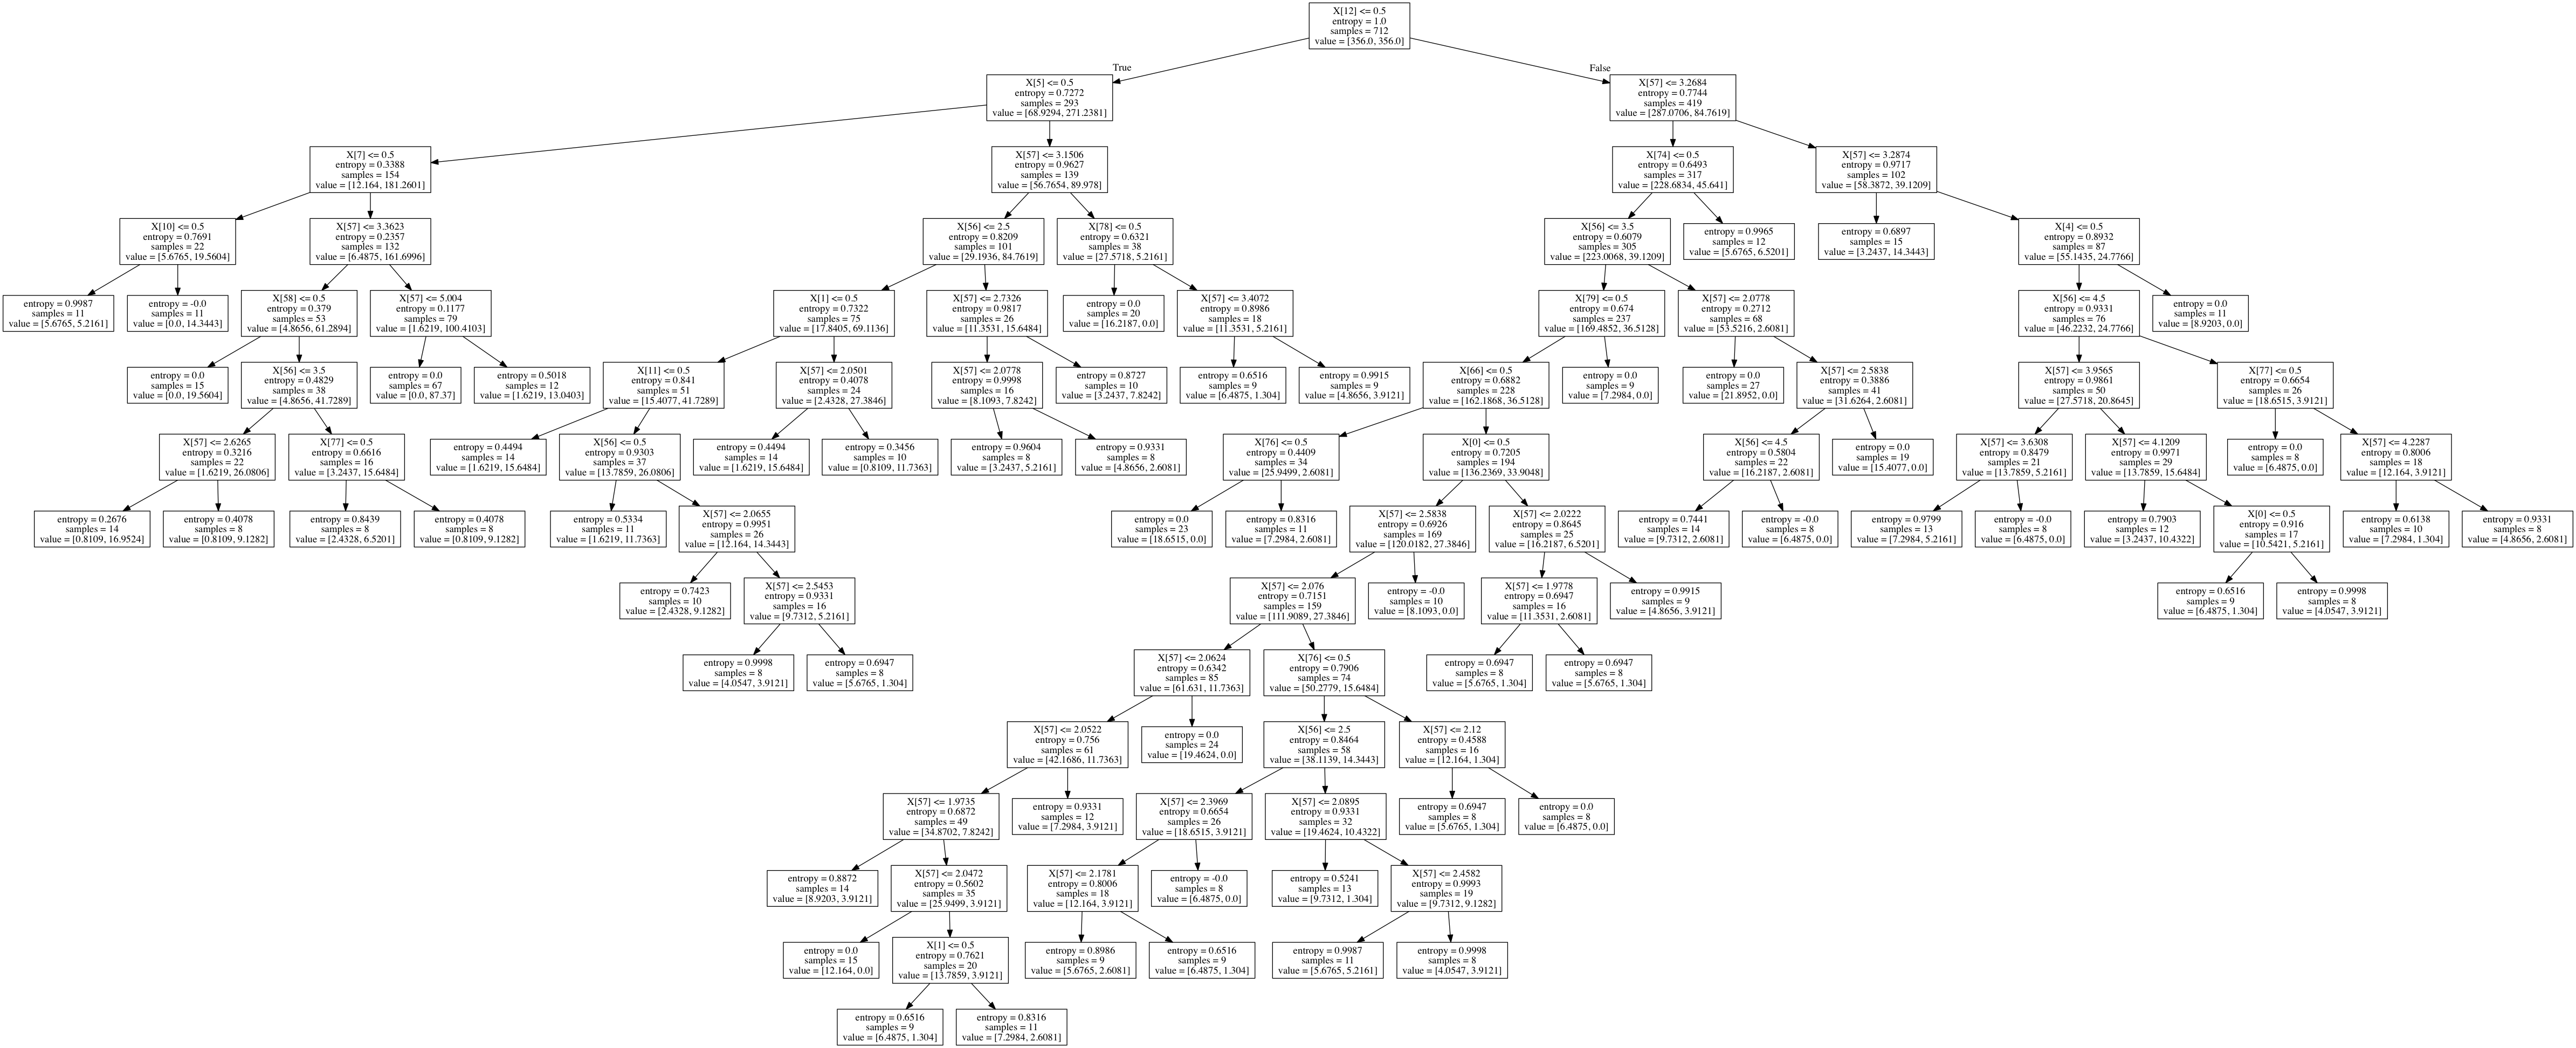

In [75]:
from sklearn import tree
treeClf = tree.DecisionTreeClassifier(criterion="entropy",min_samples_split=15,min_samples_leaf=8,class_weight='balanced')
treeClf.fit(X_train,Y_train)
print(treeClf.score(X_test,Y_test))
from sklearn.externals.six import StringIO
from IPython.display import Image, display
import pydotplus
dot_data = StringIO()
with open("titanic.dot", 'w') as f:
    f = tree.export_graphviz(treeClf, out_file=f)
tree.export_graphviz(treeClf, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
display(Image(graph.create_png())) 

Both logistic regression and decision trees get ~80% accuracy.

28 features: trEm,trPcl,trS,trTit,trfamilyID,trDe,trAge,trFare
0-2Embarked, 3-5Pclass, 6-7Sex, 8-15Title, 16-familyID, 17-25Deck, 26-Age, 27-Fare

http://blog.yhat.com/posts/random-forests-in-python.html
notes from the above website: prone to overfitting,can infer transformations and can be used for feature selection (or rather performs better with feature selection)
http://stats.stackexchange.com/questions/36165/does-the-optimal-number-of-trees-in-a-random-forest-depend-on-the-number-of-pred
how to optimally choose the number of trees. bagging (observations + features) 
In boosting, we allow many weak classifiers (high bias with low variance) to learn form their mistakes sequentially with the aim that they can correct their high bias problem while maintaining the low-variance property. In bagging, we use many overfitted classifiers (low bias but high variance) and do a bootstrap to reduce the variance. 

In [76]:
from sklearn.ensemble import RandomForestClassifier
from bokeh.charts.attributes import CatAttr
clf = RandomForestClassifier(n_estimators=400,min_samples_leaf=8,oob_score=1,n_jobs=-1)
#XtrSub = X_train[:,[7,12,6,13,57,11,5,55,3,56,46,77,66,10,2,67,76,4,58,0,78,1,51,60,59,74,79,49,50,47,48,68,70]]
#XteSub = X_test[:,[7,12,6,13,57,11,5,55,3,56,46,77,66,10,2,67,76,4,58,0,78,1,51,60,59,74,79,49,50,47,48,68,70]]

XtrSub = X_train[:,[12,7,6,57,5,11,13,55,3,56,77,4,51,2,46,76,67,58,66,0,1,78,59,10,48,60,74,49,50,79,70,47,69,68]]
XteSub = X_test[:,[12,7,6,57,5,11,13,55,3,56,77,4,51,2,46,76,67,58,66,0,1,78,59,10,48,60,74,49,50,79,70,47,69,68]]

rfClf = clf.fit(XtrSub,Y_train)
print(rfClf.score(XteSub,Y_test))
feaRank = rfClf.feature_importances_
std = np.std([rfClf.feature_importances_ for tree in rfClf.estimators_],axis=0)
indices = np.argsort(feaRank)[::-1]
print(indices[0:34])
print(feaRank[indices])
#a=np.linspace(0,len(feaRank)-1,len(feaRank))
a=np.concatenate((feaRank[indices],indices),axis=0)
a=a.reshape(2,len(feaRank)).T
fi = pd.DataFrame(a,columns=['feaRank','indices'])
p0 = Bar(fi,values='feaRank',label=CatAttr(columns=['indices'],sort=False),title="Importance of the features",legend=False, width=800, height=400)
show(p0)

0.832402234637
[ 0  2  1  3  4  5  6  7  8  9 10 14 11 13 15 18 12 23 16 17 20 21 19 22 26
 25 24 27 28 30 29 31 33 32]
[  1.97806456e-01   1.61226355e-01   1.49086728e-01   7.05890009e-02
   5.83906523e-02   5.49554263e-02   4.99065240e-02   3.39451887e-02
   3.02074686e-02   2.95611649e-02   2.38396880e-02   2.04164621e-02
   1.37644750e-02   1.10627528e-02   1.07146981e-02   1.01676657e-02
   9.22818173e-03   8.93335165e-03   8.43710369e-03   8.39537378e-03
   6.68022960e-03   6.25783017e-03   5.80215122e-03   3.86620955e-03
   3.65072824e-03   3.09998016e-03   2.50120182e-03   2.45783996e-03
   1.71781556e-03   1.33321178e-03   1.08651118e-03   8.16206157e-04
   9.53681128e-05   0.00000000e+00]


In [77]:
Xtr = XtrainLong[:,[12,7,6,57,5,11,13,55,3,56,77,4,51,2,46,76,67,58,66,0,1,78,59,10,48,60,74,49,50,79,70,47,69,68]]
Xte = XtestLong[:,[12,7,6,57,5,11,13,55,3,56,77,4,51,2,46,76,67,58,66,0,1,78,59,10,48,60,74,49,50,79,70,47,69,68]]
rfClf = clf.fit(Xtr,Ytrain)
Ypred = rfClf.predict(Xte)
ids = test_df['PassengerId'].values
predictions_file = open("titanicSub3_RF.csv", "w",newline="")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, Ypred))
predictions_file.close()

In [80]:
Y_pred = rfClf.predict(XteSub)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test,Y_pred))
ind = np.where(Y_test!=Y_pred)
print(len(ind[0]))
print(X_test[ind[0]])

[[103   7]
 [ 16  53]]
23
[[ 0.  0.  1. ...,  1.  0.  0.]
 [ 1.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  1. ...,  0.  1.  0.]
 ..., 
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  1.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]]


sorted: 
12  7  6 27 26 25 11  5 13  3 16  4  2 28  1 10  0 30 29 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import metrics, cross_validation

def modelFit(alg,Xtrain,Ytrain,performCV=True,printFeatureImportance=True,cv_folds=10):
    # fit the model
    alg.fit(Xtrain,Ytrain)
    #predict
    Ypred=alg.predict(Xtrain)
    YpredProb=alg.predict_proba(Xtrain)[:,1]
    
    if performCV:
        cv_score = cross_validation.cross_val_score(alg,Xtrain,Ytrain,cv=cv_folds,scoring='roc_auc')
        print("Accuracy :", metrics.accuracy_score(Ytrain, Ypred))
        print("AUC Score (Train):",metrics.roc_auc_score(Ytrain, YpredProb))
        print("CV Score : Mean | Std | Min| Max", [np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)])

    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

#base model
gbClf = GradientBoostingClassifier(random_state=10)
modelFit(gbClf,X_train,Y_train)
# tune number of estimators
param_test1 = {'n_estimators':np.linspace(20,100,9,dtype='int')}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=40,min_samples_leaf=20,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10),
                        param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)                        
gsearch1.fit(X_train,Y_train)
print("tuning number of estimators:")
print([gsearch1.best_params_, gsearch1.best_score_])
#gsearch1.grid_scores_

#tune max_depth & min_samples_split
param_test2 = {'max_depth':np.linspace(5,15,3,dtype='int'), 'min_samples_split':np.linspace(10,80,8,dtype='int')}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=90, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(X_train,Y_train)
print("\nmax-depth & min_samples_split:")
print([gsearch2.best_params_, gsearch2.best_score_])

#tune min_samples_leaf
param_test3 = {'min_samples_split':np.linspace(10,80,10,dtype='int'), 'min_samples_leaf':np.linspace(8,40,4,dtype='int')}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=90,max_depth=5,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train,Y_train)
print("\nmin_samples_leaf:")
print([gsearch3.best_params_, gsearch3.best_score_])

#tune max_depth
param_test4 = {'max_features':np.linspace(8,40,9,dtype='int')}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=90,max_depth=5, min_samples_split=80, min_samples_leaf=8, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train,Y_train)
print("\nmax_features:")
print([gsearch4.best_params_, gsearch4.best_score_])

#tune n_sample
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=90,max_depth=5,min_samples_split=80, min_samples_leaf=8, subsample=0.8, random_state=10,max_features=8),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,Y_train)
print("\nNsamples:")
print([gsearch5.best_params_, gsearch5.best_score_])

# now play with the learning rate: decrease learning rate and increase nestimators
# if lambda reduced by half, n_estimators is doubled
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=180,max_depth=5, min_samples_split=80,min_samples_leaf=8, subsample=0.75, random_state=10, max_features=8)
modelFit(gbm_tuned_1,X_train,Y_train)

gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=900,max_depth=5, min_samples_split=80,min_samples_leaf=8, subsample=0.75, random_state=10, max_features=8)
modelFit(gbm_tuned_2,X_train,Y_train)

gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=900,max_depth=5, min_samples_split=80,min_samples_leaf=8, subsample=0.75, random_state=10, max_features=8)
gbm_tuned_2.fit(XtrainLong,Ytrain)
Ypred = gbm_tuned_2.predict(XtestLong)

mean: 0.86310, std: 0.02817, params: {'n_estimators': 80}
{'min_samples_split': 40, 'max_depth': 5}, 0.86830335310612217]
{'min_samples_leaf': 8, 'min_samples_split': 80}, 0.86898184210618901]
{'max_features': 8}, 0.86898184210618901]


In [ ]:
ids = test_df['PassengerId'].values
predictions_file = open("titanicSub2.csv", "w",newline="")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, Ypred))
predictions_file.close()

RandomForests performs better than boosting